In [2]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

/usr/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /build/python-pytorch/src/pytorch-cuda/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
test_dataset = KittiGraphDataset(basedir, "09", graph_length=7)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
checkpoint = torch.load("./models/D/model_D_final.pth")

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [6]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  world_positions = []
  world_rotations = []

  for i, prediction in enumerate(predictions):
    if i == 0:
      world_positions.append(prediction["position"])
      world_rotations.append(prediction["rotation"])
    else:
      world_positions.append(world_positions[i-1] + prediction["position"])
      # now, rotations are in quaternion form so use appropriate function
      world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

In [7]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]

    rot = R.from_quat(rot)
    return {
        "position": pos,
        "rotation": rot,
    }

In [8]:
SELECTED_IDX = 6

predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch)
        predicted_poses.append(output.cpu().numpy()[SELECTED_IDX])
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])

100%|██████████| 1584/1584 [00:03<00:00, 418.84it/s]


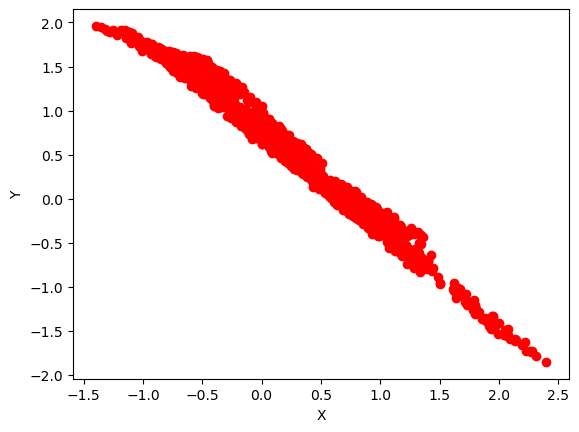

In [9]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

for pose in predicted_poses_e:
  ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

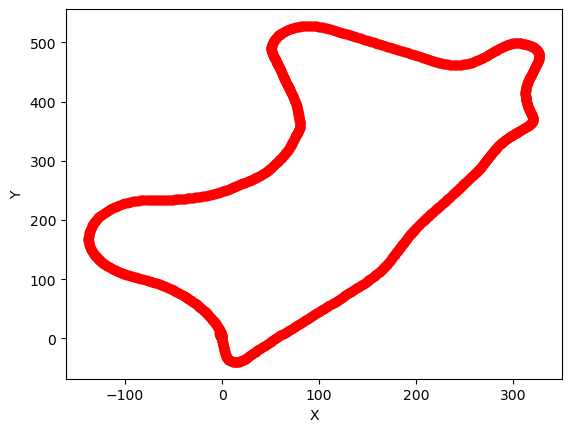

In [10]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

Predicted poses:
[{'position': array([ 0.8833134 ,  0.00147831, -0.19849305], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780ad30>}, {'position': array([ 1.0431335 ,  0.00257539, -0.34183294], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780af10>}, {'position': array([ 1.0252388 ,  0.00224328, -0.32376057], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780b000>}, {'position': array([ 1.1299212 ,  0.00206923, -0.40009934], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780b0f0>}, {'position': array([ 9.4145703e-01,  4.9707480e-05, -2.0814936e-01], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780b1e0>}, {'position': array([ 0.78206134, -0.00244534, -0.03411345], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7f3f1780b2d0>}, {'position': 

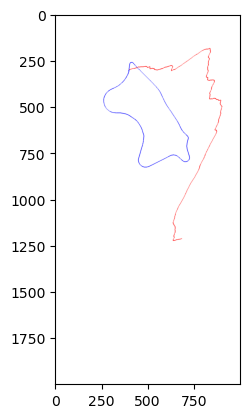

In [13]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

print("Predicted poses:")
print(predicted_poses_e)

trajectory_image = np.zeros((2000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(predicted_poses_e)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 400
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 400
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)
    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)


trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)